In [ ]:
#importing packages for environment creation
from gym import Env
from gym.spaces import Discrete, Box
#importing relevant packages
import numpy as np
import random
import matplotlib.pyplot as plt
from numpy import cos,sin,pi,arctan,arcsin,arccos,tan

In [ ]:
#installing the keras reinforcement learning module
!pip install keras-rl2

     |████████████████████████████████| 52 kB 834 kB/s 
     |████████████████████████████████| 462 kB 45.3 MB/s 


In [ ]:
#defining aircraft parameters

cb = 1.211
b = 15.47
S= 12.47
AR =19.9
m = 700
Ixx = 1073
Iyy = 907 
Izz = 1680 
Ixz = 1144 
#Thrust = 696.0711863 #800
T = 800
u0 = 55
h0 = 1500
#theta0 = 0.05
#rho = 0.85095
CD0 = 0.036
CL0 = 0.365
Cm0 = 0.05
Cd_alpha= 0.061 
CL_alpha = 5.2
Cm_alpha = -0.529
e = 0.9
g = 9.81
K = 7/(22*0.9*AR)
CL_q = 17.3 
Cm_q = -5.8
Clalfad = 8.3 
Cmalfad = -4.3
Cd_delE = 0.026
CL_delE = 0.5
Cm_delE = -1.28


CY0 = 0 
Cl0 = 0 
Cn0 = 0
CY_beta = -0.531 
Cl_beta = -0.031 
Cn_beta = 0.061
CY_p = 0.2 
Cl_p = -0.3251 
Cn_p = -0.015
CY_r = 0.633 
Cl_r = 0.1836 
Cn_r = -0.091
CY_delR = 0.15 
Cl_delR = 0.005 
Cn_delR = -0.049
CY_delA = 0 
Cl_delA = -0.153 
Cn_delA = 0

In [ ]:
#defining required functions

def sec(x):
    return 1/cos(x)

def den(h):
    R = 287
    T0 = 288.15
    P0 = 101325
    T = T0 - (6.5e-3 * h)
    P  = P0*( 1 - (6.5e-3 * h/T0))**(5.2561)
    Rho = P/(R*T)
    return Rho

def r2d(x):
    return x*180/3.14 

def Q(u,h):
    return 0.5*den(h)*u**2

def coeffs(X,V,Cin):
    u = X[0]
    v = X[1]
    w = X[2]
    pr = X[3]
    qr = X[4]
    rr  =X[5]
    alpha = arctan(X[2]/X[0]) #Angle of attack
    beta  = arcsin(X[1]/V) #Sideslip angle

    delta_e = Cin[0]
    dela    = Cin[2]
    delr    = Cin[1]
    CL = CL0 + CL_alpha*alpha + CL_q*qr*cb/(2*V) + CL_delE * delta_e;
    CD = CD0 + Cd_alpha*abs(alpha) + Cd_delE*abs(delta_e) #+ K*CL**2;
    Cm = Cm0 + Cm_alpha*alpha + Cm_q*qr*cb/(2*V) + Cm_delE * delta_e;
    CX = CL*sin(alpha) - CD*cos(alpha);
    CZ = -CL*cos(alpha) - CD*sin(alpha);
    CY = CY0 + CY_beta*beta + CY_p*(pr*b/(2*V)) + CY_r*(rr*b/(2*V)) + CY_delR*delr;
    Cl = Cl0 + Cl_beta*beta + Cl_p*(pr*b/(2*V)) + Cl_r*(rr*b/(2*V)) + Cl_delA*dela + Cl_delR*delr;
    Cn = Cn0 + Cn_beta*beta + Cn_p*(pr*b/(2*V)) + Cn_r*(rr*b/(2*V)) + Cn_delR*delr;
    Coeff = [CX, CY, CZ]
    Coefm = [Cl, Cm, Cn]
    return [Coeff, Coefm,CD]


def eu_trans(Eang):
    phi = Eang[0];
    theta = Eang[1];
    psi = Eang[2];

    T_v = np.array([[cos(theta)*cos(psi),  sin(phi)*sin(theta)*cos(psi)-cos(phi)*sin(psi),  cos(phi)*sin(theta)*cos(psi)+sin(phi)*sin(psi)],                                                    
                [cos(theta)*sin(psi),  sin(phi)*sin(theta)*sin(psi)+cos(phi)*cos(psi),  cos(phi)*sin(theta)*sin(psi)-sin(phi)*cos(psi)],
                 [-sin(theta),          sin(phi)*cos(theta),                             cos(phi)*cos(theta)]])
    T_omega = np.array([[1, tan(theta)*sin(phi), tan(theta)*cos(phi)],
           [0, cos(phi),            -sin(phi)],
           [0, sec(theta)*sin(phi), sec(theta)*cos(phi)]])
    return [T_v,T_omega]


def trim_cond(V,h):
    CLtrim = m*g/(S*Q(V,h))
    Mat_trim = np.array([[CL_alpha, CL_delE],
                         [Cm_alpha, Cm_delE]])
    B_trim = np.array([CLtrim-CL0, -Cm0])
    x_trim = np.linalg.solve(Mat_trim,B_trim)

    '''if CY_delR == 0:
        Matl = np.array([[Cl_beta, Cl_delA],
            [Cn_beta, 0]])
        B_lat = np.array([-Cl0,-Cn0])
        xlat_trim = np.linalg.solve(Matl,B_lat)
        Del_trim = [x_trim[1], xlat_trim[1]]
    else:
        Matl = np.array([[CY_beta, CY_delR, 0],
            [Cl_beta, Cl_delR, Cl_delA],
            [Cn_beta, Cn_delR, 0]])
        B_lat = np.array([-CY0,-Cl0,-Cn0])
        xlat_trim = np.linalg.solve(Matl,B_lat)
        Del_trim = [x_trim[1],xlat_trim[1],xlat_trim[2]]'''
    Matl = np.array([[CY_beta, CY_delR, 0],
            [Cl_beta, Cl_delR, Cl_delA],
            [Cn_beta, Cn_delR, 0]])
    B_lat = np.array([-CY0,-Cl0,-Cn0])
    xlat_trim = np.linalg.solve(Matl,B_lat)
    Del_trim = [x_trim[1],xlat_trim[1],xlat_trim[2]]
    return np.asarray(Del_trim)

def alpha_trim_cond(V,h):
    CLtrim = m*g/(S*Q(V,h))
    Mat_trim = np.array([[CL_alpha, CL_delE],
                         [Cm_alpha, Cm_delE]])
    B_trim = np.array([CLtrim-CL0, -Cm0])
    x_trim = np.linalg.solve(Mat_trim,B_trim)
    return x_trim[0]

def flight_model(y,t,Cin):
    #Eang,V_wind  = params
    u,v,w,p,q,r,phi,theta,psi,X,Y,h = y
    Eang = np.array([phi,theta,psi])
    #u1 = u0
    #v1 = 0
    #w1 = 0
    #vel1 = np.array([u1,v1,w1])
    omega = np.array([p,q,r])
    T_v = eu_trans(Eang)[0]
    T_omega = eu_trans(Eang)[1]
    vel = np.array([u,v,w]) 
    V = np.sqrt(u**2 + v**2 + w**2)
    #u = vel[0]
    #v = vel[1]
    #w = vel[2]
    In = np.array([[Ixx, 0, -Ixz], [0,  Iyy,  0], [-Ixz, 0, Izz]])

    I = np.identity(3)
    In_inv = np.matmul(np.linalg.inv(In),I)

    cop = np.matmul(In,omega)
    coup = np.cross(omega,cop)
     
    #rho = rho(h)

    qbar = Q(V,h)
    Cinput = Cin
    X = [u,v,w,p,q,r]
    C_F = coeffs(X,V,Cinput)[0] 
    C_Mo = coeffs(X,V,Cinput)[1]
    CD = coeffs(X,V,Cinput)[2]

    FA = np.multiply(C_F,qbar*S)   
    FA[0] = FA[0] + T ;

    M = np.array([qbar*S*C_Mo[0]*b,qbar*S*C_Mo[1]*cb, qbar*S*C_Mo[2]*b])
    ome_dot = np.matmul(In_inv,(M - coup))

    Omega_dot = np.matmul(T_omega,omega)
    Ve_dot    = np.matmul(T_v,vel)
 
    dydt = [r*v - q*w - g*sin(theta) + FA[0]/m,
            p*w - r*u + g*cos(theta)*sin(phi) + FA[1]/m,
            q*u - p*v + g*cos(theta)*cos(phi) + FA[2]/m,
            ome_dot[0],
            ome_dot[1],
            ome_dot[2],
            Omega_dot[0],
            Omega_dot[1],
            Omega_dot[2],
            Ve_dot[0],
            Ve_dot[1],
            Ve_dot[2]
            ]
    return dydt



In [ ]:
#model for longitudinal motion for the future 

def long_model(y,t,Cin):
    #Eang,V_wind  = params
    u,w,q,theta,h = y
    Eang = np.array([0,theta,0])
    #u1 = u0
    #v1 = 0
    #w1 = 0
    #vel1 = np.array([u1,v1,w1])
    omega = np.array([0,q,0])
    T_v = eu_trans(Eang)[0]
    T_omega = eu_trans(Eang)[1]
    vel = np.array([u,0,w]) 
    V = np.sqrt(u**2 + w**2)
    #u = vel[0]
    #v = vel[1]
    #w = vel[2]
    In = np.array([[Ixx, 0, -Ixz], [0,  Iyy,  0], [-Ixz, 0, Izz]])

    I = np.identity(3)
    In_inv = np.matmul(np.linalg.inv(In),I)

    cop = np.matmul(In,omega)
    coup = np.cross(omega,cop)
     
    #rho = rho(h)

    qbar = Q(V,h)
    Cinput = Cin
    X = [u,0,w,0,q,0]
    C_F = coeffs(X,V,Cinput)[0] 
    C_Mo = coeffs(X,V,Cinput)[1]
    CD = coeffs(X,V,Cinput)[2]

    FA = np.multiply(C_F,qbar*S)   
    FA[0] = FA[0] + T ;

    M = np.array([qbar*S*C_Mo[0]*b,qbar*S*C_Mo[1]*cb, qbar*S*C_Mo[2]*b])
    ome_dot = np.matmul(In_inv,(M - coup))

    Omega_dot = np.matmul(T_omega,omega)
    Ve_dot    = np.matmul(T_v,vel)
 
    '''dydt = [r*v - q*w - g*sin(theta) + FA[0]/m,
            p*w - r*u + g*cos(theta)*sin(phi) + FA[1]/m,
            q*u - p*v + g*cos(theta)*cos(phi) + FA[2]/m,
            ome_dot[0],
            ome_dot[1],
            ome_dot[2],
            Omega_dot[0],
            Omega_dot[1],
            Omega_dot[2],
            Ve_dot[0],
            Ve_dot[1],
            Ve_dot[2]
            ]'''
    '''dydt = [ q*w - g*sin(theta) + FA[0]/m,
            q*u + g*cos(theta)*cos(0) + FA[2]/m,
            ome_dot[1],
            Omega_dot[1],
            Ve_dot[2]
            ]'''
    dydt = [ q*w - g*sin(theta) + FA[0]/m,
            q*u + g*cos(theta)*cos(0) + FA[2]/m,
            M[1]/Iyy,
            q,
            w*cos(theta) - u*sin(theta)
            ]
    return dydt

In [ ]:
#integration function
def solve_get_state(Tf,t,param):
    y0,Cin = param
    y0 = np.asarray(y0)
    for i in range(int(Tf/t)):
        y0[0] = y0[0] + long_model2(y0,Cin)[0]*t
        y0[1] = y0[1] + long_model2(y0,Cin)[1]*t
    y0 = (y0[0],y0[1])
    return y0

In [ ]:
#model for the pure pitching motion currently in use

def long_model2(y,Cin):
    #Eang,V_wind  = params
    q,theta = y
    Eang = np.array([0,theta,0])
    #u1 = u0
    #v1 = 0
    #w1 = 0
    #vel1 = np.array([u1,v1,w1])
    #omega = np.array([0,q,0])
    #T_v = eu_trans(Eang)[0]
    #T_omega = eu_trans(Eang)[1]
    vel = np.array([55,0,0]) 
    V = np.sqrt(55**2 + 0**2)
    #u = vel[0]
    #v = vel[1]
    #w = vel[2]
    #In = np.array([[Ixx, 0, -Ixz], [0,  Iyy,  0], [-Ixz, 0, Izz]])

    #I = np.identity(3)
    #In_inv = np.matmul(np.linalg.inv(In),I)

    #cop = np.matmul(In,omega)
    #coup = np.cross(omega,cop)
     
    #rho = rho(h)

    qbar = Q(V,1500)
    Cinput = Cin
    X = [55*np.cos(theta),0,55*np.sin(theta),0,q,0]
    C_F = coeffs(X,V,Cinput)[0] 
    C_Mo = coeffs(X,V,Cinput)[1]
    CD = coeffs(X,V,Cinput)[2]

    FA = np.multiply(C_F,qbar*S)   
    FA[0] = FA[0] + T ;

    M = np.array([qbar*S*C_Mo[0]*b,qbar*S*C_Mo[1]*cb, qbar*S*C_Mo[2]*b])
    #ome_dot = np.matmul(In_inv,(M - coup))

    #Omega_dot = np.matmul(T_omega,omega)
    #Ve_dot    = np.matmul(T_v,vel)
 
    '''dydt = [r*v - q*w - g*sin(theta) + FA[0]/m,
            p*w - r*u + g*cos(theta)*sin(phi) + FA[1]/m,
            q*u - p*v + g*cos(theta)*cos(phi) + FA[2]/m,
            ome_dot[0],
            ome_dot[1],
            ome_dot[2],
            Omega_dot[0],
            Omega_dot[1],
            Omega_dot[2],
            Ve_dot[0],
            Ve_dot[1],
            Ve_dot[2]
            ]'''
    '''dydt = [ q*w - g*sin(theta) + FA[0]/m,
            q*u + g*cos(theta)*cos(0) + FA[2]/m,
            ome_dot[1],
            Omega_dot[1],
            Ve_dot[2]
            ]'''
    dydt = (
            M[1]/Iyy,
            q,
              )
    return dydt

In [ ]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

#Environment modified inside the CartPoleEnv; the name still persists 

import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np


class CartPoleEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self):
        self.cb = 1.211
        self.b = 15.47
        self.S= 12.47
        self.AR =19.9
        self.m = 700
        self.Ixx = 1073
        self.Iyy = 907 
        self.Izz = 1680 
        self.Ixz = 1144 
        self.Thrust = 696.0711863 #800
        self.T = 800
        self.u0 = 55
        self.h0 = 1500
        self.CD0 = 0.036
        self.CL0 = 0.365
        self.Cm0 = 0.05
        self.Cd_alpha= 0.061 
        self.CL_alpha = 5.2
        self.Cm_alpha = -0.529
        self.e = 0.9
        self.g = 9.81
        self.K = 7/(22*0.9*AR)
        self.CL_q = 17.3 
        self.Cm_q = -5.8
        self.Clalfad = 8.3 
        self.Cmalfad = -4.3
        self.Cd_delE = 0.026
        self.CL_delE = 0.5
        self.Cm_delE = -1.28
        self.CY0 = 0 
        self.Cl0 = 0 
        self.Cn0 = 0
        self.CY_beta = -0.531 
        self.Cl_beta = -0.031 
        self.Cn_beta = 0.061
        self.CY_p = 0.2 
        self.Cl_p = -0.3251 
        self.Cn_p = -0.015
        self.CY_r = 0.633 
        self.Cl_r = 0.1836 
        self.Cn_r = -0.091
        self.CY_delR = 0.15 
        self.Cl_delR = 0.005 
        self.Cn_delR = -0.049
        self.CY_delA = 0 
        self.Cl_delA = -0.153 
        self.Cn_delA = 0  
        self.tau = 0.02 # seconds between state updates
        self.clock = 0
        self.controls = trim_cond(self.u0,self.h0)
        self.dele = self.controls[0]
        self.moment = Cm_delE*self.dele
        self.my_history = [0]
        self.action_history = [0]
        self.my_history2 = [0]
        self.my_history3 = [0]
        self.reward_history = [0]
        import random as rd
        i = np.random.randint(low = -5,high = 5 )
        self.ttr = i*3.14/180 
        self.steps = 1
        

        #defining bounds 
        d = np.finfo(dtype = np.float32).max
        high = np.array([d,d,d],
                        dtype=np.float32)
        low = np.array([-d,-d,-d],
                        dtype=np.float32)
        

        #self.moments_array = np.linspace(Cm_delE*15*math.pi/180,Cm_delE*(-15)*math.pi/180,100)
        low1 = np.array([Cm_delE*15*math.pi/180],dtype = np.float32)
        high1 = np.array([-Cm_delE*15*math.pi/180],dtype = np.float32)



        self.action_space = spaces.Box(low1,high1)
        #self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low, high)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None
        self.max_steps = 300


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        #print(action)
        action = np.clip(action,Cm_delE*15*math.pi/180,-Cm_delE*15*math.pi/180)
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg
        

        (q,dtheta,theta) = self.state
        self.moment = action
        self.action_history.append(self.moment)
        self.steps+=1 

        new_state = solve_get_state(self.tau,self.tau/40,( (q,theta),   ((self.moment)/Cm_delE,self.controls[1],self.controls[2])))
        ans = new_state
        self.state = (ans[0], ans[1] - self.ttr, ans[1])
        #print(self.state)
        done1 = False
        done2 = False
        done = False
        if self.state[2] >  0.17453:
            done1 = 1
        elif self.state[2] <  -0.17453:
            done1 = 1
        done2 = bool(self.steps >= self.max_steps)
        if done1 == True or done2 == True:
            done = True
        self.my_history.append(self.moment[0]/(Cm_delE))
        self.my_history2.append(self.state[2]*180/3.14)
        self.my_history3.append(ans[0])

        a = r2d(self.state[1])
        b = self.state[0]
        c = abs(r2d(self.my_history[-1] - (self.moment[0])/Cm_delE))


        reward = -a**2 - b**2 - c
        if r2d(abs(self.state[1])) < 1:
            reward = reward + 10*(1  - a**2) 


        self.reward_history.append(reward)


        return self.state, reward, done, {}

    def reset(self):
        #self.ttr = self.target_list[self.steps]
        b = np.random.uniform(low = -5*math.pi/180,high = 5*math.pi/180)
        self.state  = (np.random.uniform(low = -0.05,high = 0.05),b, self.ttr + b)
        self.dele = self.controls[0]
        self.steps = 0
        self.moment = Cm_delE*self.dele
        self.my_history = []
        self.my_history2 = []
        self.my_history3 = [self.state[0]]
        self.reward_history = []
        self.action_history = []
        return self.state

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

In [ ]:
#traning block

import numpy as np
import gym
import tensorflow

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, Concatenate
from tensorflow.keras.optimizers import Adam

from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess


#ENV_NAME = 'Pendulum-v0'


# Get the environment and extract the number of actions.
env = CartPoleEnv()
np.random.seed(123)
env.seed(123)
#assert len(env.action_space.shape) == 1
nb_actions = 1
#print(env.ttr)

# Next, we build a very simple model.
actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Activation('relu'))
actor.add(Dense(400))
actor.add(Activation('relu'))
actor.add(Dense(400))
actor.add(Activation('relu'))
#actor.add(Dense(32))
#actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('linear'))
#print(actor.summary())

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(300)(x)
x = Activation('relu')(x)
x = Dense(300)(x)
x = Activation('relu')(x)
#x = Dense(32)(x)
#x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)

#rint(critic.summary())
# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=1000000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.2)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process= random_process, gamma=.99, target_model_update=1e-3)
agent.compile(Adam(learning_rate=.0001, clipnorm=1.), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
agent.fit(env, nb_steps=900000, visualize=False, verbose=1, nb_max_episode_steps=299)

Training for 900000 steps ...
Interval 1 (0 steps performed)
    5/10000 [..............................] - ETA: 2:19 - reward: -4.6886 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


10000/10000 [==============================] - 307s 31ms/step - reward: -7.4650
178 episodes - episode_reward: -421.038 [-14111.334, 1165.116] - loss: 151.570 - mae: 9.071 - mean_q: -37.035

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 301s 30ms/step - reward: 1.3098
34 episodes - episode_reward: 371.809 [-2843.474, 2635.984] - loss: 111.429 - mae: 3.888 - mean_q: -10.800

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 301s 30ms/step - reward: 4.7883
33 episodes - episode_reward: 1408.616 [-1251.243, 2761.979] - loss: 101.503 - mae: 2.982 - mean_q: 66.797

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 299s 30ms/step - reward: 5.5194
34 episodes - episode_reward: 1660.177 [-453.979, 2824.603] - loss: 99.075 - mae: 2.536 - mean_q: 153.975

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 299s 30ms/step - reward: 5.3813
33 episodes - episode_reward: 

Testing for 1 episodes ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Episode 1: reward: -1800.350, steps: 300
-1800.3500383468768
(300,)
-1.0000000000000002


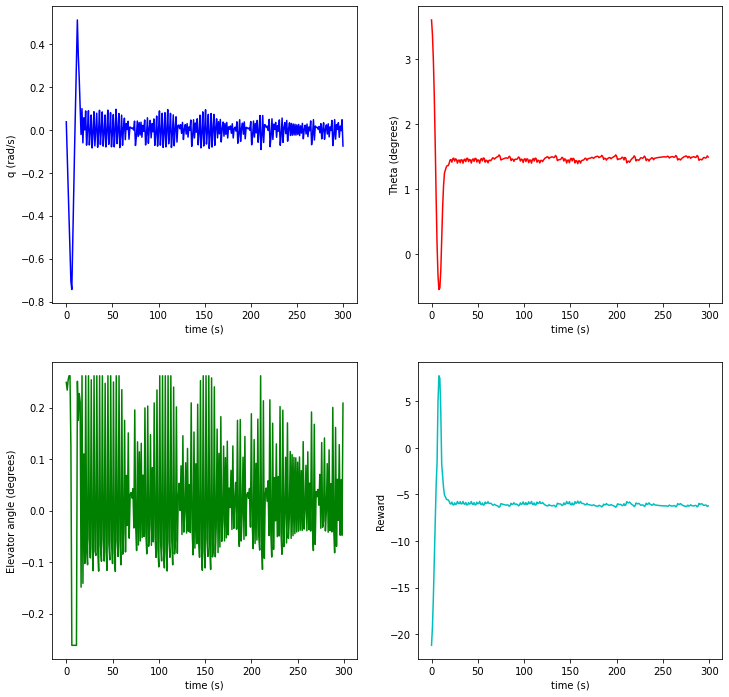

In [ ]:
# check results here for a random initialization 

env1 = CartPoleEnv()
import matplotlib.pyplot as plt

scores = agent.test(env1, nb_episodes=1,visualize = False)
print(np.mean(scores.history['episode_reward']))
print(np.shape(env1.my_history))
print(env1.ttr*180/3.14)

figure, axis = plt.subplots(2, 2,figsize = (12,12))
plt1 = axis[0, 0] 
plt2 = axis[0, 1] 
plt3 = axis[1, 0] 
plt4 = axis[1, 1]


#plt3.plot(np.linspace(0,1000*0.02,1000),env1.my_history,'-g')
plt3.plot(env1.my_history,'-g')
plt3.set_xlabel('time (s)')
plt3.set_ylabel('Elevator angle (degrees)')


plt2.plot(env1.my_history2,'-r')
a  = env1.my_history2[-1]
#plt2.text(6,1, ('Final value',np.round(a,4)),bbox = dict(facecolor = 'red', alpha = 0.5))
plt2.set_xlabel('time (s)')
plt2.set_ylabel('Theta (degrees)')


#plt1.plot(np.linspace(0,1001*0.02,1001),env1.my_history3,'-b')
plt1.plot(env1.my_history3,'-b')
plt1.set_xlabel('time (s)')
plt1.set_ylabel('q (rad/s)')



#plt4.plot(np.linspace(0,1000*0.02,1000),env1.reward_history,'-c')
plt4.plot(env1.reward_history,'-c')
plt4.set_xlabel('time (s)')
plt4.set_ylabel('Reward')

plt.show()

In [ ]:
# If above results good then save model which will be available for download in the session storage tab in the files tab on the left.
actor.save('ddpg_end_results_3.h5')
# use this in the testing_ground.ipynb